# `strategic-fl-sim`: Shakespeare Demo Experiment

Demonstrating strategic federated learning with a free-riding client

In [9]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from shakespearedataset import ShakespeareDataset
from torch import nn
from torch.utils.data import DataLoader

from models import LSTM
from strategicflsim.agents import Client, Server
from strategicflsim.utils.actions import FreeRidingAction, ScalarAction
from strategicflsim.utils.aggregation import get_aggregate
from strategicflsim.utils.evaluate import evaluate_with_ids
from strategicflsim.utils.metrics import NormMetrics

## Preparation/initialization

### Setup device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
elif torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple M-series
else:
    device = torch.device("cpu")  # CPU

print(f"Using device: {device}")

Using device: mps


### Setup experiment configuration

In [15]:
config = {
    "training": {
        "T": 1000,
        "lr": 0.06,
        "local_steps": 1,
        "batch_size": 16,
        "eval_batch_size": 64,
    },
    "clients": {
        "n_players": 10,
        "alpha_0": 1.0,
        "alpha_1": 1.0,
        "beta_0": 0.0,
        "beta_1": 0.0,
    },
    "aggregation": {"method": "mean"},
    "data": {
        "train_path": "../../data/shakespeare/train.json",
        "test_path": "../../data/shakespeare/test.json",
        "truncate_size": 1000,
    },
    "model": {"seq_len": 80, "num_classes": 80, "n_hidden": 256, "embedding_dim": 8},
}

print("Configuration:")
for section, values in config.items():
    print(f"  {section}:")
    for key, value in values.items():
        print(f"    {key}: {value}")

Configuration:
  training:
    T: 1000
    lr: 0.06
    local_steps: 1
    batch_size: 16
    eval_batch_size: 64
  clients:
    n_players: 10
    alpha_0: 1.0
    alpha_1: 1.0
    beta_0: 0.0
    beta_1: 0.0
  aggregation:
    method: mean
  data:
    train_path: ../../data/shakespeare/train.json
    test_path: ../../data/shakespeare/test.json
    truncate_size: 1000
  model:
    seq_len: 80
    num_classes: 80
    n_hidden: 256
    embedding_dim: 8


### Loading the Shakespeare data

In [16]:
def get_data(path: str):
    with open(path, "r") as f:
        data = json.load(f)
        user_names = data["users"]
        data_dict = data["user_data"]
    return data_dict, user_names


print("\nLoading Shakespeare data...")
data_dict, user_names = get_data(config["data"]["train_path"])
test_data_dict, _ = get_data(config["data"]["test_path"])

print(f"Training data: {len(user_names)} users")
print(f"Sample user data size: {len(data_dict[user_names[0]]['x'])} samples")

# DATA TRUNCATION
if config["data"]["truncate_size"] > 0:
    print(f"Truncating data to last {config['data']['truncate_size']} samples...")

    for key in data_dict.keys():
        try:
            if (
                isinstance(data_dict[key], dict)
                and "x" in data_dict[key]
                and "y" in data_dict[key]
            ):
                data_dict[key]["x"] = data_dict[key]["x"][
                    -config["data"]["truncate_size"] :
                ]
                data_dict[key]["y"] = data_dict[key]["y"][
                    -config["data"]["truncate_size"] :
                ]
        except Exception as e:
            print(f"Error processing key {key}: {e}")

    for key in test_data_dict.keys():
        try:
            if (
                isinstance(test_data_dict[key], dict)
                and "x" in test_data_dict[key]
                and "y" in test_data_dict[key]
            ):
                test_data_dict[key]["x"] = test_data_dict[key]["x"][
                    -config["data"]["truncate_size"] :
                ]
                test_data_dict[key]["y"] = test_data_dict[key]["y"][
                    -config["data"]["truncate_size"] :
                ]
        except Exception as e:
            print(f"Error processing test key {key}: {e}")


Loading Shakespeare data...
Training data: 799 users
Sample user data size: 400 samples
Truncating data to last 1000 samples...


### Creating a Server agent with LSTM model

In [ ]:
# This cell uses the package

print("\nCreating server...")
server_model = LSTM(
    seq_len=config["model"]["seq_len"],
    num_classes=config["model"]["num_classes"],
    n_hidden=config["model"]["n_hidden"],
    embedding_dim=config["model"]["embedding_dim"],
).to(device)

server = Server(
    device=device,
    model=server_model,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(server_model.parameters(), lr=config["training"]["lr"]),
    aggregate_fn=get_aggregate(method=config["aggregation"]["method"]),
    agent_id="server",
)

print(f"Created server with {config['aggregation']['method']} aggregation")



Creating server...
Created server with mean aggregation


### Creating a group of Client agents
All but one clients are honest, one client is free-riding.

In [ ]:
print("\nCreating clients...")
split_index = len(user_names) // config["clients"]["n_players"]
clients = []

for i in range(config["clients"]["n_players"]):
    start_idx = max(0, i * split_index)
    end_idx = min((i + 1) * split_index, len(user_names))
    client_user_names = user_names[start_idx:end_idx]

    if i == config["clients"]["n_players"] - 1:
        alpha = config["clients"]["alpha_1"]
        beta = config["clients"]["beta_1"]
        agent_id = "free-riding"
        print(
            f"  Client {i + 1}: BAD - {len(client_user_names)} users"
        )
        action = ScalarAction(alpha, beta) # FreeRidingAction()
    else:
        alpha = config["clients"]["alpha_0"]
        beta = config["clients"]["beta_0"]
        agent_id = f"honest{i}"
        print(
            f"  Client {i + 1}: GOOD - {len(client_user_names)} users"
        )
        action = ScalarAction(alpha, beta)

    train_dataset = ShakespeareDataset(client_user_names, data_dict)
    test_dataset = ShakespeareDataset(client_user_names, test_data_dict)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config["training"]["batch_size"],
        shuffle=True,
        pin_memory=True if device.type == "cuda" else False,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=config["training"]["eval_batch_size"],
        shuffle=False,
        pin_memory=True if device.type == "cuda" else False,
    )

    # The lines below use the package
    client_model = LSTM(
        seq_len=config["model"]["seq_len"],
        num_classes=config["model"]["num_classes"],
        n_hidden=config["model"]["n_hidden"],
        embedding_dim=config["model"]["embedding_dim"],
    ).to(device)

    client = Client(
        device=device,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        model=client_model,
        criterion=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(
            client_model.parameters(), lr=config["training"]["lr"]
        ),
        action=action,
        agent_id=agent_id,
    )

    clients.append(client)



Creating clients...
  Client 1: GOOD - 79 users
  Client 2: GOOD - 79 users
  Client 3: GOOD - 79 users
  Client 4: GOOD - 79 users
  Client 5: GOOD - 79 users
  Client 6: GOOD - 79 users
  Client 7: GOOD - 79 users
  Client 8: GOOD - 79 users
  Client 9: GOOD - 79 users
  Client 10: BAD - 79 users


## Run federated training

In [ ]:
# This cell uses the package
print(f"\nStarting federated training for {config['training']['T']} rounds...")

# all_losses, all_metrics = server.train(
#     clients=clients,
#     T=config["training"]["T"],
#     get_metrics=get_gradient_metrics,
# )

server.train(
    clients=clients,
    T=config["training"]["T"],
    metrics_fn=NormMetrics(
        save_path="./results/shakespeare_honest_mean",
        client_ids=[client.agent_id for client in clients],
    ),
)

print("Training completed!")


Starting federated training for 1000 rounds...


Federated Training: 100%|██████████| 1000/1000 [02:42<00:00,  6.15it/s]

Training completed!


## Evaluate final performance

In [ ]:
# This cell uses the package
print("\nEvaluating final performance...")
final_accuracy, final_loss = evaluate_with_ids(server, clients)


Evaluating final performance...
good0: Accuracy = 0.1888, Loss = 3.1420
good1: Accuracy = 0.1887, Loss = 3.1308
good2: Accuracy = 0.1864, Loss = 3.1482
good3: Accuracy = 0.1895, Loss = 3.1392
good4: Accuracy = 0.1872, Loss = 3.1458
good5: Accuracy = 0.1900, Loss = 3.1421
good6: Accuracy = 0.1874, Loss = 3.1250
good7: Accuracy = 0.1885, Loss = 3.1378
good8: Accuracy = 0.1897, Loss = 3.1518
bad: Accuracy = 0.1880, Loss = 3.1557


In [ ]:
final_free_riding_loss = {'good0': 3.1454603210728913,
 'good1': 3.1351367274970228,
 'good2': 3.1504397167923495,
 'good3': 3.142640443710574,
 'good4': 3.148824616232484,
 'good5': 3.14642685907066,
 'good6': 3.1285437587358347,
 'good7': 3.1419497522779536,
 'good8': 3.1548685360575646,
 'bad': 3.1597691210079164}

In [ ]:
final_honest_loss = {'good0': 3.1420443890188854,
 'good1': 3.130832377943801,
 'good2': 3.1481936327408806,
 'good3': 3.1392249199820994,
 'good4': 3.1458445928262,
 'good5': 3.142084602327784,
 'good6': 3.125009277534943,
 'good7': 3.137783117714579,
 'good8': 3.151771900458308,
 'bad': 3.155716280246488}

## Visualize training process

Figure saved as './results/shakespeare_free_riding_comparison.pdf'


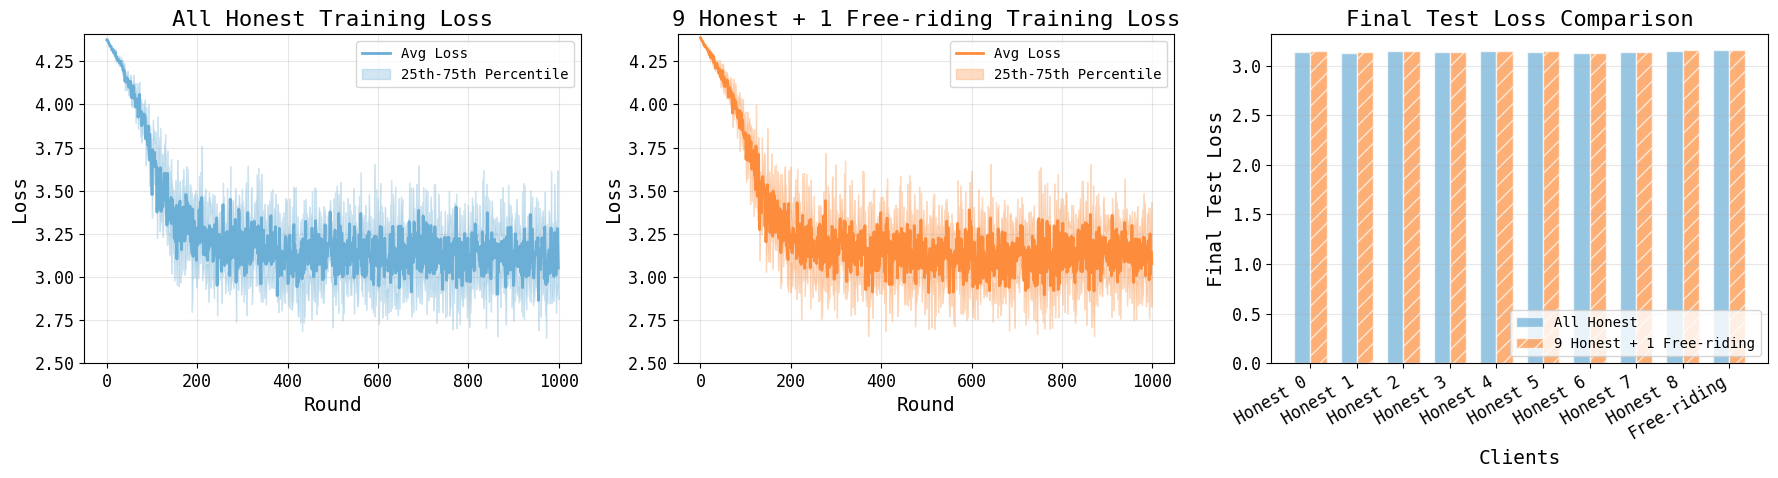

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def load_run_data(save_name):
    """Load metrics for a single run."""
    losses_df = pd.read_csv(f"{save_name}_losses.csv")
    rounds = losses_df["round"].values
    losses_array = losses_df.drop("round", axis=1).values
    return rounds, losses_array


plt.rcParams.update(
    {
        "font.family": "monospace",
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

# Color scheme - Paired palette (colorblind-safe)
color_palette = sns.color_palette(palette="tab20c")
color_good = color_palette[1]  # light blue
color_bad = color_palette[5]  # light orange

# Load both runs
save_name_honest = "./results/shakespeare_honest_mean"
save_name_byz = "./results/shakespeare_free_riding_mean"

rounds_honest, losses_honest = load_run_data(save_name_honest)
rounds_byz, losses_byz = load_run_data(save_name_byz)

# Calculate statistics for both
mean_honest = losses_honest.mean(axis=1)
p25_honest = np.percentile(losses_honest, 25, axis=1)
p75_honest = np.percentile(losses_honest, 75, axis=1)

mean_byz = losses_byz.mean(axis=1)
p25_byz = np.percentile(losses_byz, 25, axis=1)
p75_byz = np.percentile(losses_byz, 75, axis=1)

# Calculate shared y-axis limits
all_losses = np.concatenate([losses_honest.flatten(), losses_byz.flatten()])
y_min, y_max = 2.5, all_losses.max()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Honest training loss
axes[0].plot(
    rounds_honest, mean_honest, label="Avg Loss", color=color_good, linewidth=2
)
axes[0].fill_between(
    rounds_honest,
    p25_honest,
    p75_honest,
    alpha=0.3,
    color=color_good,
    label="25th-75th Percentile",
)
axes[0].set_ylim(y_min, y_max)
axes[0].set_title("All Honest Training Loss")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss")
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3, which="both")

# Plot 2: Byzantine training loss
axes[1].plot(rounds_byz, mean_byz, label="Avg Loss", color=color_bad, linewidth=2)
axes[1].fill_between(
    rounds_byz,
    p25_byz,
    p75_byz,
    alpha=0.3,
    color=color_bad,
    label="25th-75th Percentile",
)
axes[1].set_ylim(y_min, y_max)
axes[1].set_title("9 Honest + 1 Free-riding Training Loss")
axes[1].set_xlabel("Round")
axes[1].set_ylabel("Loss")
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, which="both")

# Plot 3: Final loss comparison - grouped bars
client_ids = list(final_honest_loss.keys())
losses_honest_final = [float(final_honest_loss[cid]) for cid in client_ids]
losses_byz_final = [float(final_free_riding_loss[cid]) for cid in client_ids]

x = np.arange(len(client_ids))
width = 0.35

axes[2].bar(
    x - width / 2,
    losses_honest_final,
    width,
    label="All Honest",
    color=color_good,
    alpha=0.7,
    edgecolor="white",
)
axes[2].bar(
    x + width / 2,
    losses_byz_final,
    width,
    label="9 Honest + 1 Free-riding",
    color=color_bad,
    alpha=0.7,
    edgecolor="white",
    hatch="//",
)

axes[2].set_xlabel("Clients")
axes[2].set_ylabel("Final Test Loss")
axes[2].set_title("Final Test Loss Comparison")
axes[2].set_xticks(x)
for i in range(len(client_ids) - 1):
    client_ids[i] = f"Honest {i}"
client_ids[-1] = "Free-riding"
axes[2].set_xticklabels(client_ids, rotation=30, ha="right")
axes[2].legend(loc="lower right", fontsize=10)
axes[2].grid(axis="y", alpha=0.3)

plt.tight_layout()
fig_filename = "./results/shakespeare_free_riding_comparison"
plt.savefig(f"{fig_filename}.pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved as '{fig_filename}.pdf'")
plt.show()

Figure saved as 'shakespeare_training_metrics.png'


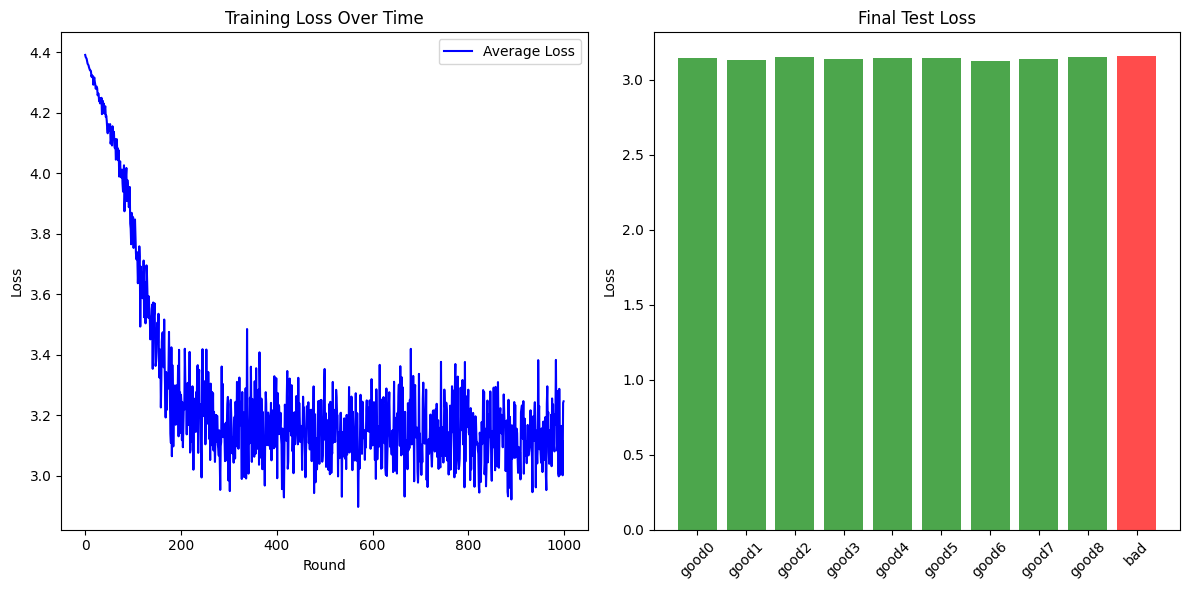

In [ ]:
losses_array = np.array(
    [[loss for loss in round_losses] for round_losses in all_losses]
)
grad_norms_array = np.array([metrics["grad_norms"] for metrics in all_metrics])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training losses over time
axes[0].plot(losses_array.mean(axis=1), label="Average Loss", color="blue")
axes[0].set_title("Training Loss Over Time")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Final loss bar plot
client_ids = list(final_loss.keys())
loss = [float(final_loss[client_id]) for client_id in client_ids]
colors = [
    "red"
    if "adversarial" in client_id.lower() or "bad" in client_id.lower()
    else "green"
    for client_id in client_ids
]
axes[1].bar(client_ids, loss, color=colors, alpha=0.7)
axes[1].set_title("Final Test Loss")
axes[1].set_ylabel("Loss")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()

# Save the figure to file
fig_filename = 'shakespeare_training_metrics'
plt.savefig(f'{fig_filename}.png', dpi=300, bbox_inches='tight')
print(f"Figure saved as '{fig_filename}.png'")

plt.show()

### [Optional] Saving the results

In [ ]:
results = {
    "config": config,
    "final_accuracy": final_accuracy,
    "final_loss": final_loss,
    "training_losses": losses_array,
    "gradient_norms": grad_norms_array,
}

with open("strategicflsim_demo_shakespeare.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to strategicflsim_demo_shakespeare.pkl")

Results saved to strategicfl_demo_shakespeare.pkl
